## TED Lens Logistic Regression Code

Importing Libraries

In [1]:
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

import gensim
import gensim.downloader as api


c:\Users\chris\anaconda3\envs\TEDLens\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data Exploration 

Data Preprocessing

In [2]:
data = pd.read_csv('./TED_Talks_Dataset/2020-05-01/ted_talks_en.csv')

xtraining_column = 'description'
useful_data = data[[xtraining_column, 'topics']]
useful_data.head()

,description,topics
0,With the same humor and humanity he exuded in ...,"['alternative energy', 'cars', 'climate change..."
1,You've never seen data presented like this. Wi...,"['Africa', 'Asia', 'Google', 'demo', 'economic..."
2,New York Times columnist David Pogue takes aim...,"['computers', 'entertainment', 'interface desi..."
3,"In an emotionally charged talk, MacArthur-winn...","['MacArthur grant', 'activism', 'business', 'c..."
4,Sir Ken Robinson makes an entertaining and pro...,"['children', 'creativity', 'culture', 'dance',..."


In [3]:
# Load the CSV dataset
data = useful_data

# converting the text to 
all_topics = []
for topics,i in zip(data['topics'],range(len(data['topics']))):
    all_topics+=eval(topics)
    data['topics'][i] = eval(topics)

unique_topics = sorted(list(set(all_topics)))
print(unique_topics)

['3D printing', 'AI', 'AIDS', 'Africa', "Alzheimer's", 'Antarctica', 'Anthropocene', 'Asia', 'Audacious Project', 'Autism spectrum disorder', 'Best of the Web', 'Brand', 'Brazil', 'Buddhism', 'CRISPR', 'Christianity', 'DNA', 'Debate', 'Egypt', 'Europe', 'Foreign Policy', 'Gender spectrum', 'God', 'Google', 'HIV', 'Humanities', 'Internet', 'Iran', 'Islam', 'LGBT', 'Latin America', 'MacArthur grant', 'Mars', 'Middle East', 'Moon', 'NASA', 'New York', 'Nobel Prize', 'PTSD', 'Planets', 'Science (hard)', 'Senses', 'Slavery', 'Social Science', 'South America', 'String theory', 'Sun', 'Surgery', 'Syria', 'TED Books', 'TED Connects', 'TED Fellows', 'TED Prize', 'TED Residency', 'TED en Español', 'TED-Ed', 'TEDMED', 'TEDNYC', 'TEDYouth', 'TEDx', 'Transgender', 'United States', 'Vaccines', 'activism', 'addiction', 'adventure', 'advertising', 'aging', 'agriculture', 'aircraft', 'algorithm', 'alternative energy', 'ancient world', 'animals', 'animation', 'anthropology', 'ants', 'apes', 'archaeology

In [4]:
info = api.info()  # show info about available models/datasets
word2vec_model = api.load("word2vec-google-news-300")  # download the model and return as object ready for use
word2vec_model.most_similar("cat")

[('cats', 0.8099379539489746),
 ('dog', 0.760945737361908),
 ('kitten', 0.7464985251426697),
 ('feline', 0.7326234579086304),
 ('beagle', 0.7150582671165466),
 ('puppy', 0.7075453400611877),
 ('pup', 0.6934291124343872),
 ('pet', 0.6891531348228455),
 ('felines', 0.6755931973457336),
 ('chihuahua', 0.6709762215614319)]

In [5]:
def column_to_word2vec_embeddings(dataframe, column_name, word2vec_model):

    # Get the text from the specified column
    texts = dataframe[column_name]
    
    # Initialize a list to store Word2Vec embeddings
    embeddings = []

    # Iterate through the texts and convert to Word2Vec embeddings
    for text in texts:
        tokens = text.split()  # Tokenize the text
        word_embeddings = [word2vec_model[token] for token in tokens if token in word2vec_model]
        if word_embeddings:
            # Calculate the paragraph embedding (average of word embeddings)
            paragraph_embedding = np.mean(word_embeddings, axis=0)
        else:
            # Handle the case where there are no word embeddings
            paragraph_embedding = np.zeros(word2vec_model.vector_size)
        embeddings.append(paragraph_embedding)

    # Create a new DataFrame with the embeddings
    modified_dataframe = dataframe.copy()
    modified_dataframe[column_name] = embeddings

    return modified_dataframe


In [6]:
vectorized_data = column_to_word2vec_embeddings(data, xtraining_column, word2vec_model)
vectorized_data.head()

,description,topics
0,"[0.12422338, 0.06567518, 0.016583804, 0.074134...","[alternative energy, cars, climate change, cul..."
1,"[0.093926325, 0.057295058, 0.011302524, -0.001...","[Africa, Asia, Google, demo, economics, global..."
2,"[0.028200233, 0.07740643, -0.009277344, -0.001...","[computers, entertainment, interface design, m..."
3,"[0.060469408, 0.08431101, 0.030822754, 0.01545...","[MacArthur grant, activism, business, cities, ..."
4,"[-0.0025284712, 0.04734533, 0.009388194, 0.035...","[children, creativity, culture, dance, educati..."


In [7]:
from sklearn.preprocessing import MultiLabelBinarizer

multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(vectorized_data['topics'])

# transform target variable
y = multilabel_binarizer.transform(vectorized_data['topics'])

for i in range(len(vectorized_data['topics'])):
    vectorized_data['topics'][i] = y[i]

In [8]:
vectorized_data.head()

,description,topics
0,"[0.12422338, 0.06567518, 0.016583804, 0.074134...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0.093926325, 0.057295058, 0.011302524, -0.001...","[0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0.028200233, 0.07740643, -0.009277344, -0.001...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[0.060469408, 0.08431101, 0.030822754, 0.01545...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[-0.0025284712, 0.04734533, 0.009388194, 0.035...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Splitting the data to test and train

In [9]:
X_train, X_test, Y_train, Y_test = train_test_split(vectorized_data[xtraining_column], vectorized_data['topics'], test_size=0.2, random_state=42)

Basic Model Training

In [10]:
from sklearn.linear_model import LogisticRegression

# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier

# Performance metric
from sklearn.metrics import f1_score

We are using the most basic Logistic Regression and inorder to convert into a multilabel text classification problem, we use one more layer called OneVsRestClassifier.

In [11]:
#### Builiding the model

lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

# fit model on train data
clf.fit(np.array(list(X_train)), np.array(list(Y_train)))
#Predict movie genres on the validation set:

OneVsRestClassifier(estimator=LogisticRegression())

Model Testing and Evaluation

In [12]:
# make predictions for validation set
y_pred = clf.predict(np.array(list(X_test)))

In [13]:
y_pred[10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [14]:
multilabel_binarizer.inverse_transform(y_pred)[10]

('design', 'technology')

In [15]:
f1_score(np.array(list(Y_test)), y_pred, average="micro")

0.11049400760011693

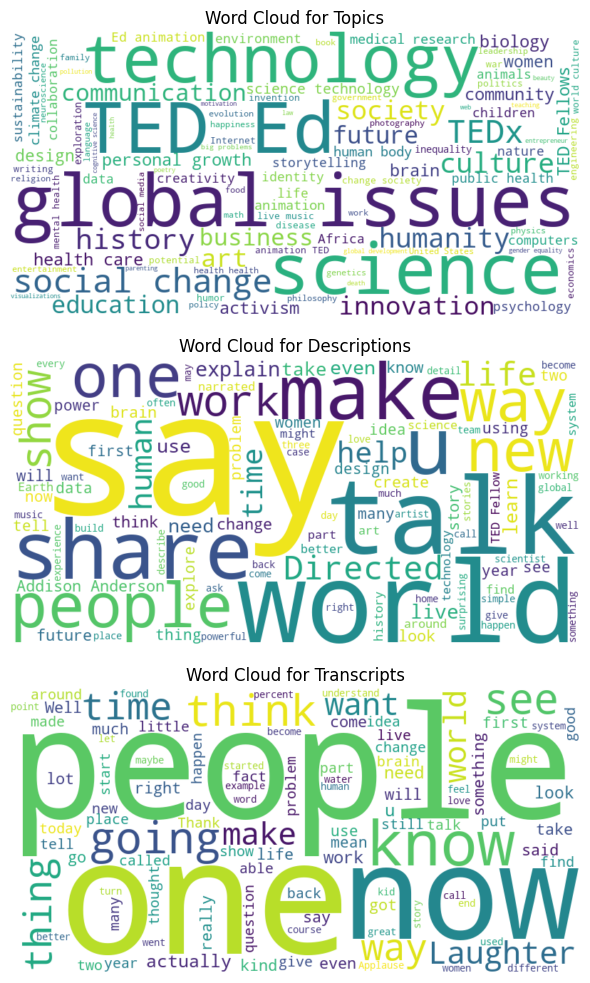

In [16]:
import pandas as pd
import ast
from wordcloud import WordCloud        
import matplotlib.pyplot as plt        

# Load the data
df = pd.read_csv('./TED_Talks_Dataset/2020-05-01/ted_talks_en.csv')

# Generate word cloud for topics
topics = df['topics'].apply(ast.literal_eval).tolist()
flattened_topics = [item for sublist in topics for item in sublist]
text_topics = ' '.join(flattened_topics)
wordcloud_topics = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_topics)

# Generate word cloud for descriptions
text_description = ' '.join(df['description'].dropna())
wordcloud_description = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_description)

# Generate word cloud for transcripts
text_transcript = ' '.join(df['transcript'].dropna())
wordcloud_transcript = WordCloud(width=800, height=400, background_color='white', max_words=100).generate(text_transcript)

# Plotting the word clouds
fig, axs = plt.subplots(3, 1, figsize=(6, 10))

# Topics
axs[0].imshow(wordcloud_topics, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title("Word Cloud for Topics")

# Descriptions
axs[1].imshow(wordcloud_description, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title("Word Cloud for Descriptions")

# Transcripts
axs[2].imshow(wordcloud_transcript, interpolation='bilinear')
axs[2].axis('off')
axs[2].set_title("Word Cloud for Transcripts")

plt.tight_layout()
plt.show()

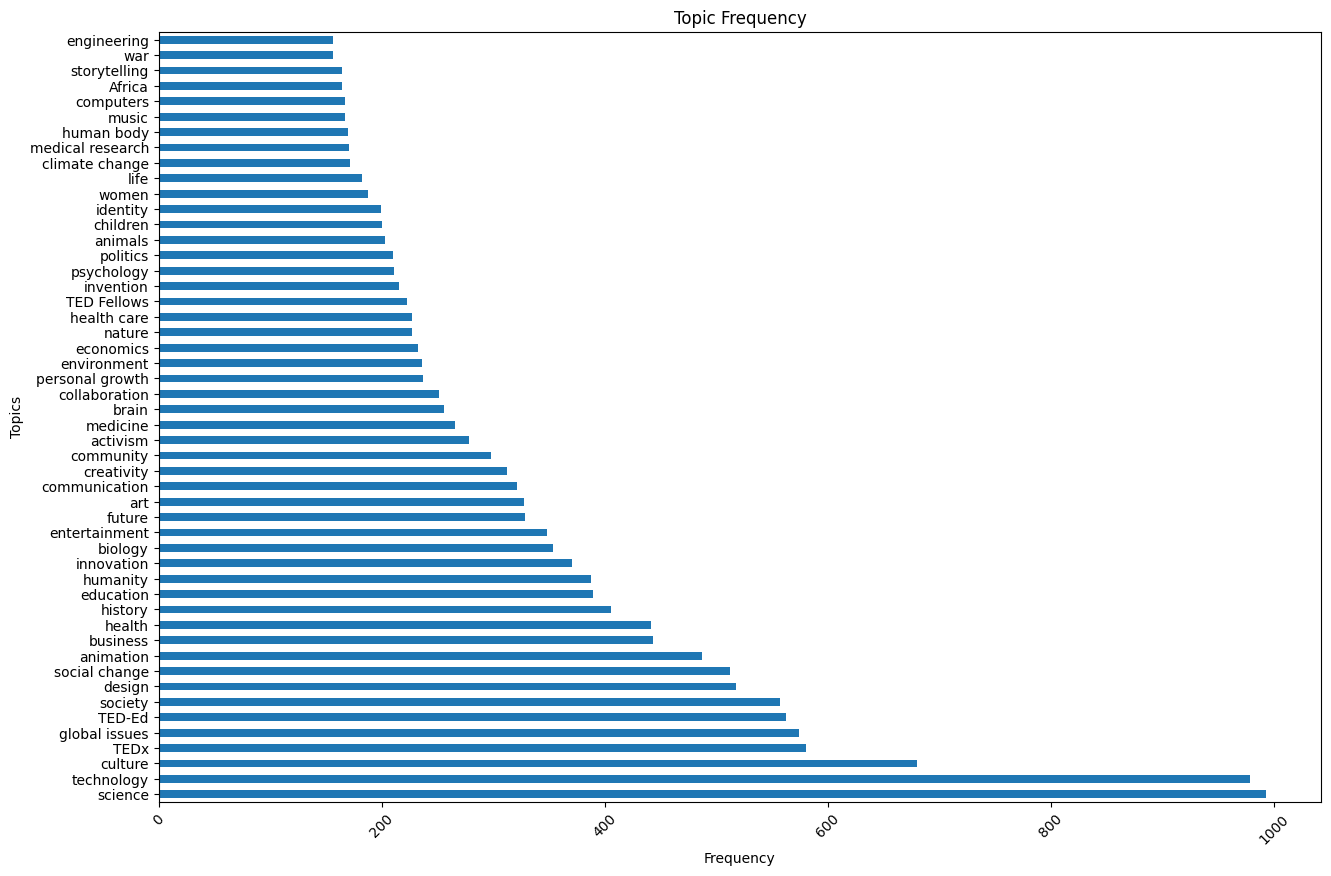

<Figure size 640x480 with 0 Axes>

In [17]:
# Create a Pandas Series for easy counting
topics_series = pd.Series(flattened_topics)

# Calculate the frequency of each topic
topic_counts = topics_series.value_counts()

top_topics = topic_counts.head(50)
# Plot the bar graph of topic frequency
plt.figure(figsize=(15, 10))
top_topics.plot(kind='barh')
plt.title('Topic Frequency')
plt.xlabel('Frequency')
plt.ylabel('Topics')
plt.xticks(rotation=45)
plt.show()
plt.savefig('topic_frequency.png')

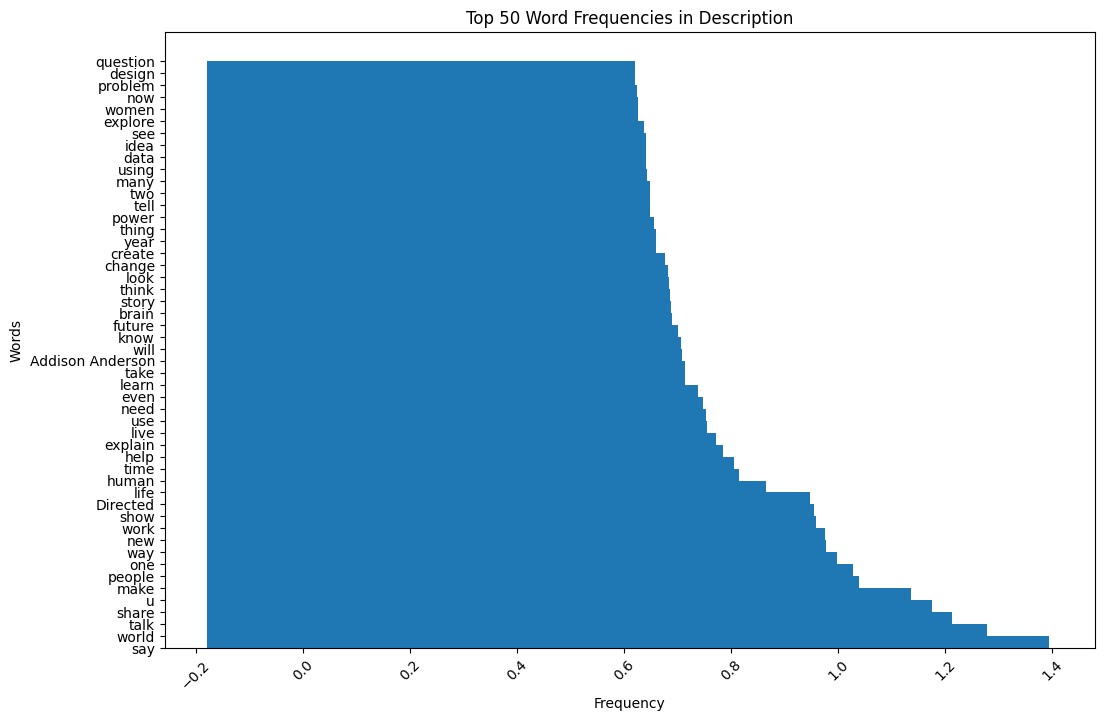

<Figure size 640x480 with 0 Axes>

In [18]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming you have your data loaded into a DataFrame, 'df'

# Concatenate all 'description' text data into a single string
text_description = ' '.join(df['description'].dropna())

# Generate a word cloud
wordcloud_description = WordCloud(width=800, height=400, background_color='white', max_words=500).generate(text_description)

# Plot the bar graph of the most frequent words in 'description'
plt.figure(figsize=(12, 8))
word_frequencies = wordcloud_description.words_
word_frequencies = {word: freq for word, freq in sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:50]}
plt.bar(word_frequencies.values(), word_frequencies.keys())
plt.title('Top 50 Word Frequencies in Description')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.xticks(rotation=45)
plt.show()
plt.savefig('top_50_description.png')

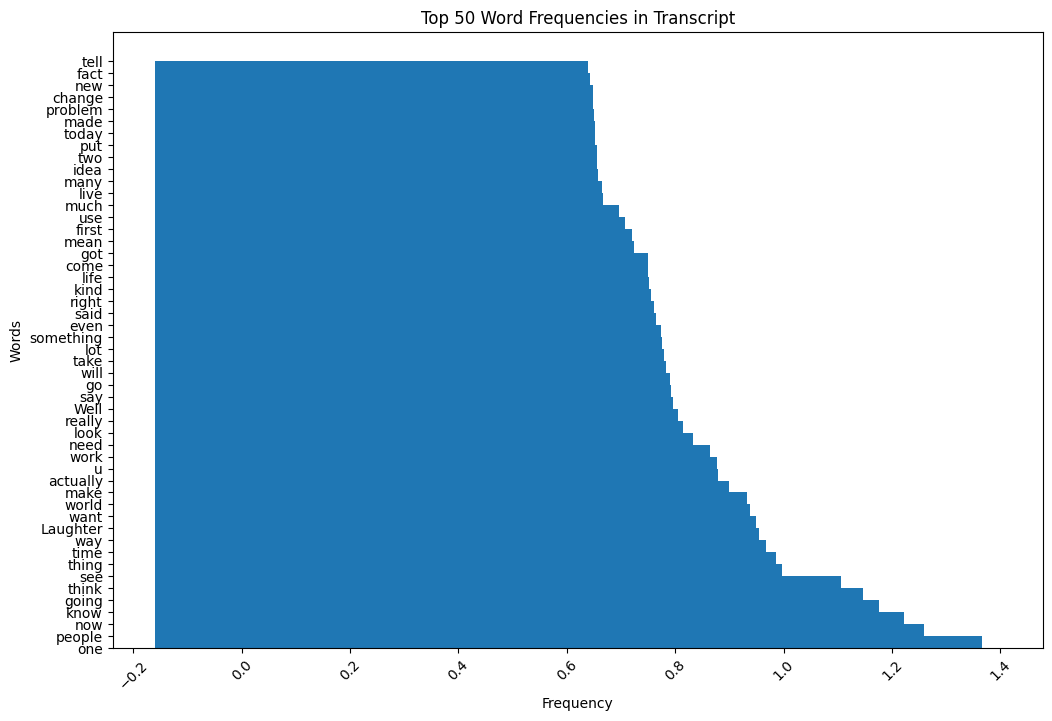

<Figure size 640x480 with 0 Axes>

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assuming you have your data loaded into a DataFrame, 'df'

# Concatenate all 'description' text data into a single string
text_description = ' '.join(df['transcript'].dropna())

# Generate a word cloud
wordcloud_description = WordCloud(width=800, height=400, background_color='white', max_words=500).generate(text_description)

# Plot the bar graph of the most frequent words in 'description'
plt.figure(figsize=(12, 8))
word_frequencies = wordcloud_description.words_
word_frequencies = {word: freq for word, freq in sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True)[:50]}
plt.bar(word_frequencies.values(), word_frequencies.keys())
plt.title('Top 50 Word Frequencies in Transcript')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.xticks(rotation=45)
plt.show()
plt.savefig('top_50_transcript.png')

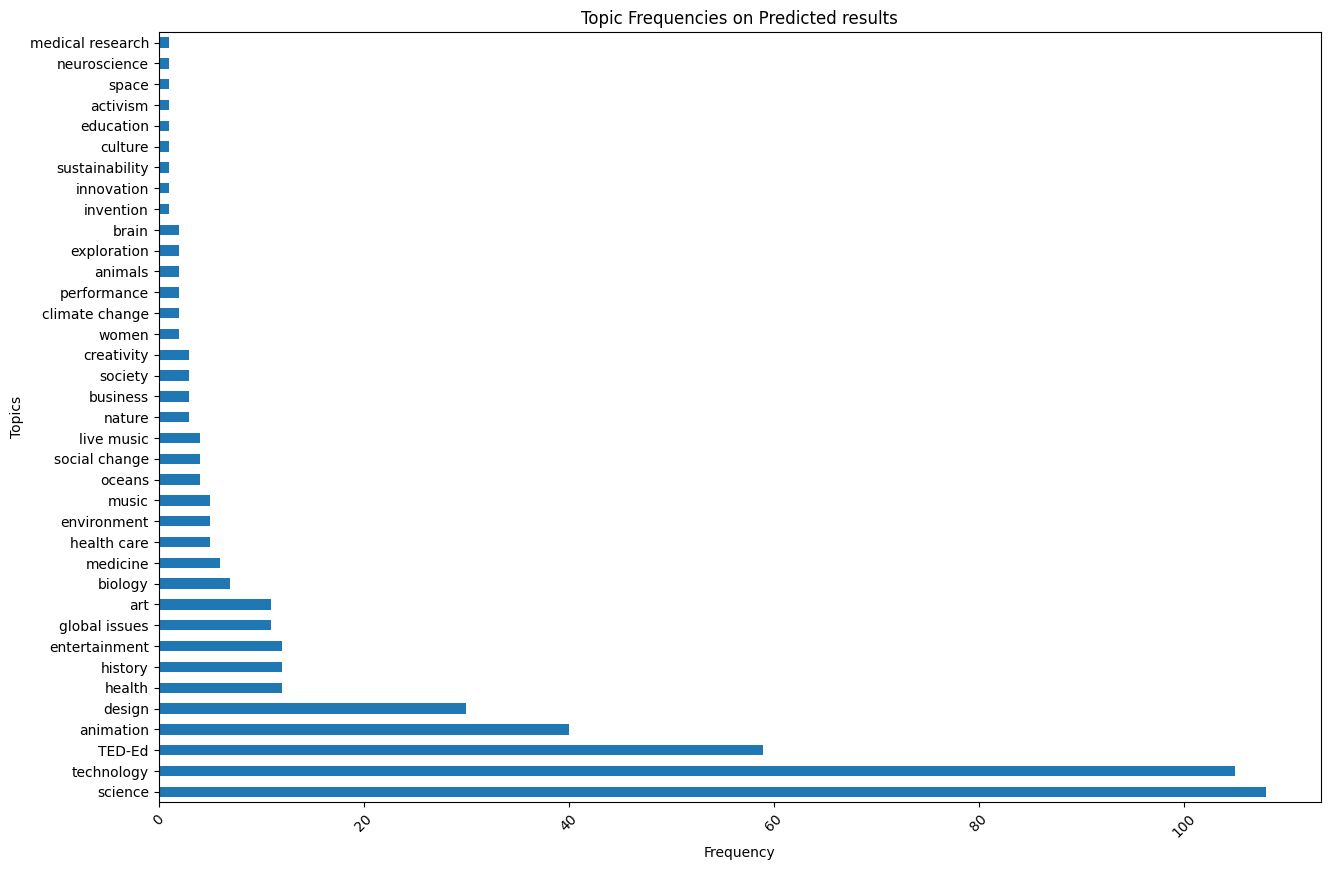

<Figure size 640x480 with 0 Axes>

In [20]:
inverse_labels = multilabel_binarizer.inverse_transform(y_pred)

flattened_topics_predicted = [item for sublist in inverse_labels for item in sublist]

# Create a Pandas Series for easy counting
topics_series = pd.Series(flattened_topics_predicted)

# Calculate the frequency of each topic
topic_counts = topics_series.value_counts()

top_topics = topic_counts.head(50)

# Plot the bar graph of topic frequency
plt.figure(figsize=(15, 10))
top_topics.plot(kind='barh')
plt.title('Topic Frequencies on Predicted results')
plt.xlabel('Frequency')
plt.ylabel('Topics')
plt.xticks(rotation=45)
plt.show()
plt.savefig('topic_frequency_model_prediction.png')

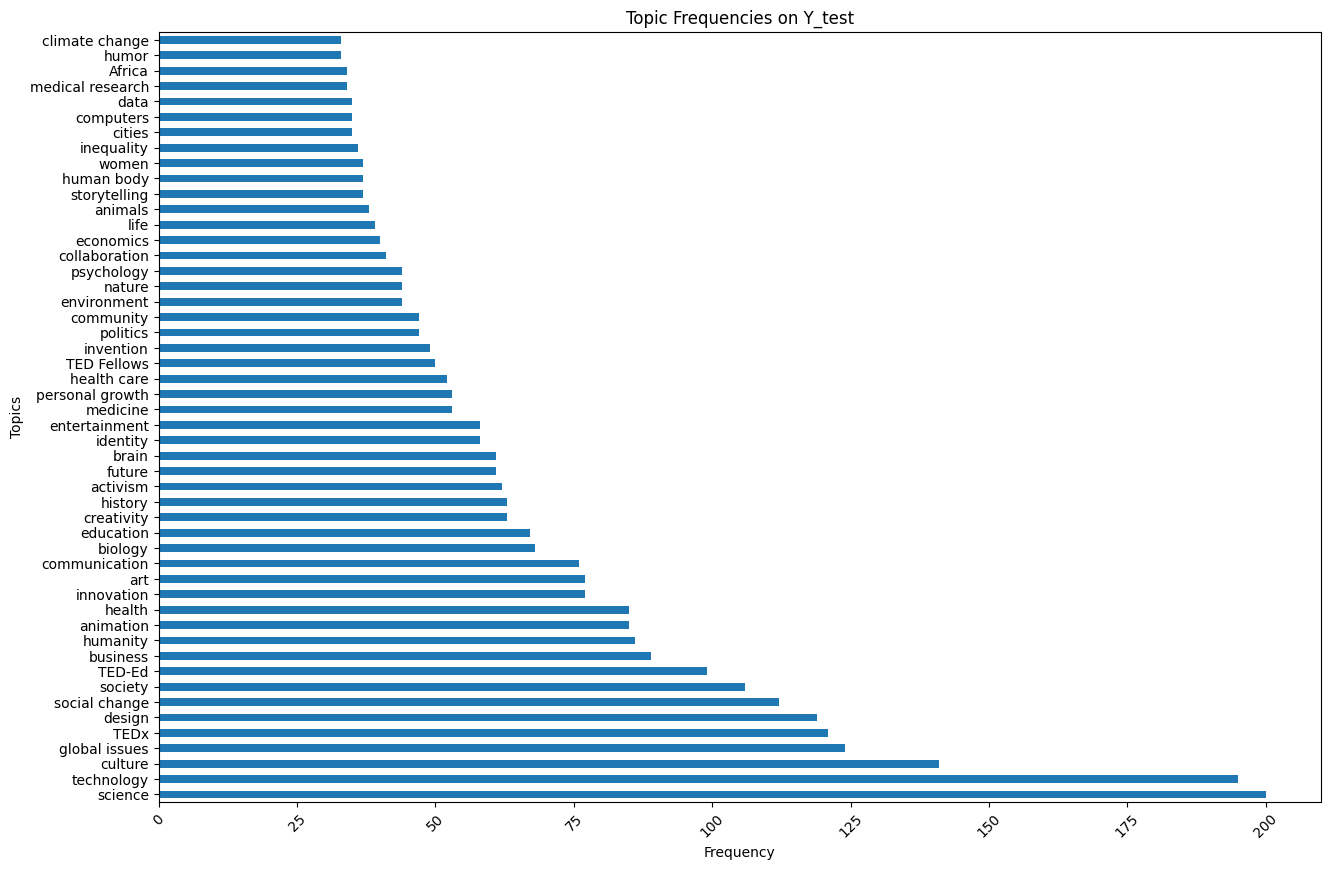

<Figure size 640x480 with 0 Axes>

In [21]:
inverse_labels = multilabel_binarizer.inverse_transform(np.array(list(Y_test)))

flattened_topics_predicted = [item for sublist in inverse_labels for item in sublist]

# Create a Pandas Series for easy counting
topics_series = pd.Series(flattened_topics_predicted)

# Calculate the frequency of each topic
topic_counts = topics_series.value_counts()
top_topics = topic_counts.head(50)

# Plot the bar graph of topic frequency
plt.figure(figsize=(15, 10))
top_topics.plot(kind='barh')
plt.title('Topic Frequencies on Y_test')
plt.xlabel('Frequency')
plt.ylabel('Topics')
plt.xticks(rotation=45)
plt.show()
plt.savefig('topic_frequencies_Y_test.png')

Analyzing the average number of tags generated by the model

In [22]:
inverse_labels_Y_test = multilabel_binarizer.inverse_transform(np.array(list(Y_test)))
inverse_labels_Y_pred = multilabel_binarizer.inverse_transform(np.array(list(y_pred)))

## Average tags per transcript
average_tags_in_Y_test = sum([len(i) for i in inverse_labels_Y_test])/len([len(i) for i in inverse_labels_Y_test])
average_tags_in_Y_pred = sum([len(i) for i in inverse_labels_Y_pred])/len([len(i) for i in inverse_labels_Y_pred])

print(f'Average no.of tags in Y_test : {average_tags_in_Y_test} , Y_pred : {average_tags_in_Y_pred}')

Average no.of tags in Y_test : 7.951310861423221 , Y_pred : 0.5905118601747815
